# Finance Club: DTL Project Member Application - Ashwin Kilingar ME22B111


## please note:
The Time Fusion Transformer Code cells are compute intensive, kindly run then by uncommenting only if you have cuda compute

# Data Processing



In [182]:
import pandas as pd

df = pd.read_csv('data.csv', parse_dates=['Date'])
df["Date"] = pd.to_datetime(df["Date"])
for col in df.columns:
    if col != 'Date':
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('float64')
df.set_index('Date', inplace=True)
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82 entries, 2018-01-01 to 2024-10-01
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Total_Sales      82 non-null     float64
 1   Brent_Oil        82 non-null     float64
 2   RBI_Repo         82 non-null     float64
 3   CPI              82 non-null     float64
 4   Inflation        82 non-null     float64
 5   Urban CPI        82 non-null     float64
 6   Urban Inflation  82 non-null     float64
 7   Steel            82 non-null     float64
 8   Aluminium        82 non-null     float64
 9   FII              82 non-null     float64
 10  DII              82 non-null     float64
 11  NIFTY AUTO       82 non-null     float64
 12  NIFTY 50         82 non-null     float64
 13  USD_INR          82 non-null     float64
 14  Google Trends    82 non-null     float64
 15  TAMO Price       79 non-null     float64
dtypes: float64(16)
memory usage: 10.9 KB
None
  

In [183]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import *
import matplotlib.pyplot as plt
import seaborn as sns


# === Missing Value Handling ===
# Forward fill for rates and stable economic indicators
ffill_cols = ['RBI_Repo', 'CPI', 'Inflation', 'Urban CPI', 'Urban Inflation', 'USD_INR']
df[ffill_cols] = df[ffill_cols].fillna(method='ffill')

# Linear interpolation for continuous features
interpolate_cols = ['Brent_Oil', 'Steel', 'Aluminium', 'Google Trends']
df[interpolate_cols] = df[interpolate_cols].interpolate(method='linear')

# Drop rows if critical features are still missing
df.dropna(inplace=True)

# === Outlier Detection and Capping using z-scores ===
def cap_outliers(series, z_thresh=3):
    z_scores = (series - series.mean()) / series.std()
    capped = series.copy()
    capped[z_scores > z_thresh] = series.mean() + z_thresh * series.std()
    capped[z_scores < -z_thresh] = series.mean() - z_thresh * series.std()
    return capped

for col in df.columns:
    df[col] = cap_outliers(df[col])

# === Standardization ===

# === Define groups ===
minmax_cols = ['RBI_Repo', 'CPI', 'Inflation', 'Urban CPI', 'Urban Inflation','Total_Sales'] # Low-variance data
standard_cols = ['Brent_Oil', 'Steel', 'Aluminium', 'USD_INR', 'NIFTY AUTO', 'NIFTY 50'] # z-score normalizes distribution
robust_cols = ['FII', 'DII', 'Google Trends'] # Less sensitive to outliers

# === Apply scalers ===
scalers = {
    'minmax': MinMaxScaler(),
    'standard': StandardScaler(),
    'robust': RobustScaler()
}

scaled_df = pd.DataFrame(index=df.index)

# Scale by group
scaled_df[minmax_cols] = scalers['minmax'].fit_transform(df[minmax_cols])
scaled_df[standard_cols] = scalers['standard'].fit_transform(df[standard_cols])
scaled_df[robust_cols] = scalers['robust'].fit_transform(df[robust_cols])
scaled_df['TAMO'] = df['TAMO Price']
df.dropna(inplace=True)



# === Save cleaned version ===
scaled_df.to_csv("preprocessed_tatamotors_data.csv")


# Data Analysis

Comparison of Correlations between data and Tata Motors Price. The data that I have chosen look good as there is strong correlations across the board for the Share Price.

Top Pearson correlations:
 TAMO          1.000000
NIFTY AUTO    0.967689
NIFTY 50      0.918523
CPI           0.828123
Urban CPI     0.814465
USD_INR       0.727913
Steel         0.562824
Brent_Oil     0.559784
Aluminium     0.527669
RBI_Repo      0.424427
Name: TAMO, dtype: float64

Top Spearman correlations:
 TAMO          1.000000
NIFTY AUTO    0.955057
NIFTY 50      0.857649
Brent_Oil     0.799895
Urban CPI     0.776935
CPI           0.775436
Aluminium     0.752865
Steel         0.741879
USD_INR       0.689358
RBI_Repo      0.433135
Name: TAMO, dtype: float64


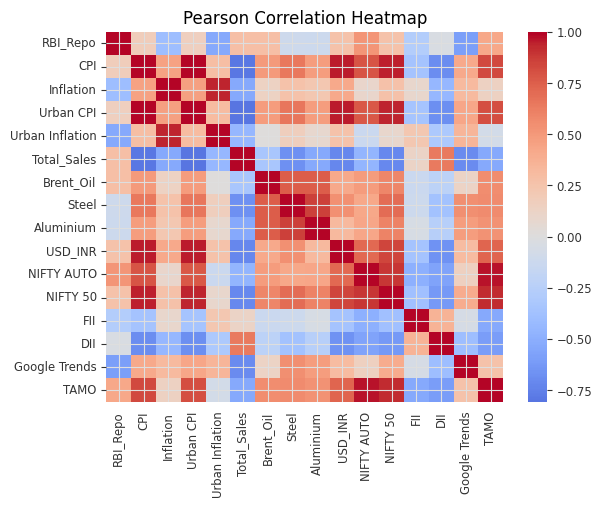

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt

df = scaled_df

# Pearson and Spearman TAMO
pearson_corr = df.corr()['TAMO'].sort_values(ascending=False)
spearman_corr = df.corr(method='spearman')['TAMO'].sort_values(ascending=False)

print("Top Pearson correlations:\n", pearson_corr.head(10))
print("\nTop Spearman correlations:\n", spearman_corr.head(10))


# Plot heatmap
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Pearson Correlation Heatmap")
plt.show()



Here, I am experimenting with the data to understand whether rolling correlations exist within the data. I observe the plots for different values of the roll period and understand how the dependance varies with time.

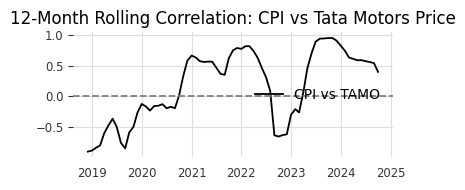

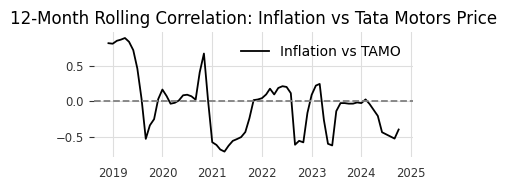

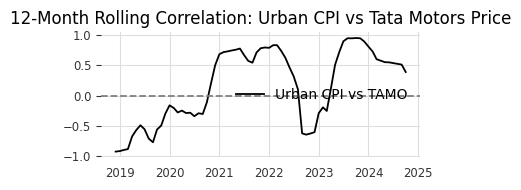

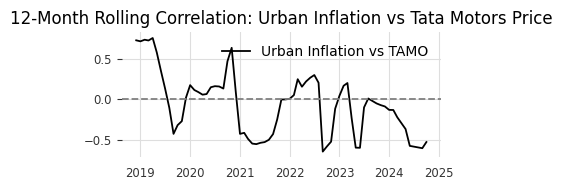

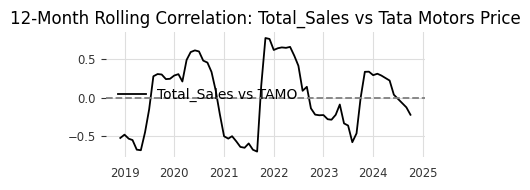

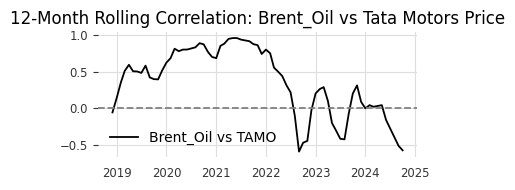

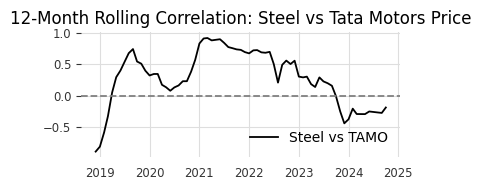

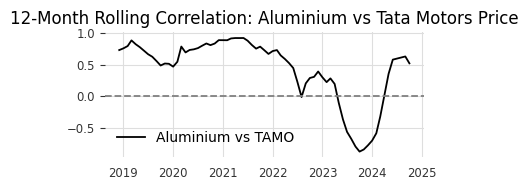

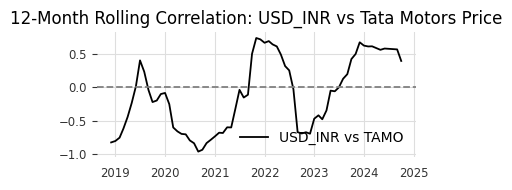

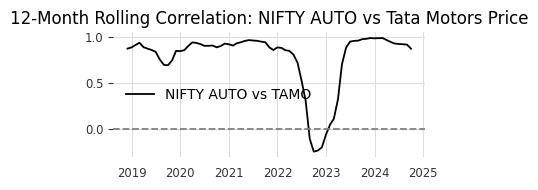

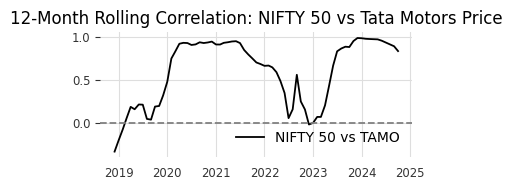

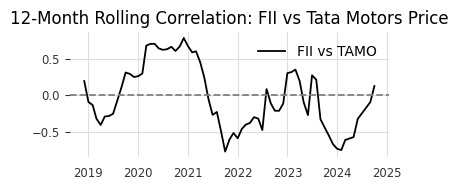

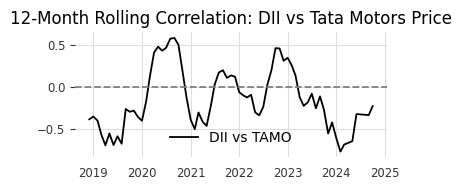

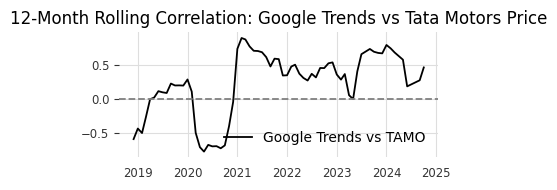

In [185]:
roll_period = 12

columns = df.columns
for col in columns:
    if col == 'TAMO' or col == 'RBI_Repo':
        continue 
    rolling_corr = df[col].rolling(roll_period).corr(df['TAMO'])  

    plt.figure(figsize=(4, 2))
    plt.plot(rolling_corr, label=f'{col} vs TAMO')
    plt.title(f"{roll_period}-Month Rolling Correlation: {col} vs Tata Motors Price")
    plt.axhline(0, linestyle='--', color='gray')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

To obtain the best lagged relations, I'll be using the Granger causality test. 

Before we do that, I begin by running the ADF test to ensure that the variables are stationary. I am running the ADF test upto the 3rd order difference.

Then I run the granger test and obtain the best lagged features and their p-values to determine the confidence

In [186]:
from statsmodels.tsa.stattools import adfuller

def make_stationary(df, significance=0.05):
    stationary_data = pd.DataFrame(index=df.index)
    diff_required = {}

    for col in df.columns:
        series = df[col].dropna()
        pval = adfuller(series)[1]
        if pval < significance:
            stationary_data[col] = series
            diff_required[col] = 0
        else:
            # Difference until stationary
            diff = 1
            while diff <= 3:  # max 3 diff attempts
                new_series = series.diff(diff).dropna()
                if adfuller(new_series)[1] < significance:
                    stationary_data[col] = new_series
                    diff_required[col] = diff
                    break
                diff += 1
            else:
                print(f"Could not make {col} stationary.")
    return stationary_data.dropna(), diff_required


from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

def granger_test_suite(df, target='TAMO', max_lag=6):
    results = []
    features = df.columns.drop(target)

    for feature in features:
        pvals = {}
        for lag in range(1, max_lag+1):
            try:
                test_result = grangercausalitytests(df[[target, feature]], maxlag=lag, verbose=False)
                pval = test_result[lag][0]['ssr_chi2test'][1]
                pvals[f'lag_{lag}'] = pval
            except Exception as e:
                pvals[f'lag_{lag}'] = np.nan
        min_p = min(pvals.values())
        best_lag = min(pvals, key=pvals.get)
        results.append({
            'Feature': feature,
            'Best_Lag': best_lag,
            'Min_pval': min_p,
            **pvals
        })

    return pd.DataFrame(results).sort_values('Min_pval')


stationary_df, diff_info = make_stationary(df)
stationary_df.dropna(inplace=True)

# Step 1: Run Granger tests
gc_result_df = granger_test_suite(stationary_df)

# Step 2: Display Top Predictors
print(gc_result_df[['Feature', 'Best_Lag', 'Min_pval']].head(10))


Could not make RBI_Repo stationary.
            Feature Best_Lag  Min_pval
11              FII    lag_5  0.000127
3   Urban Inflation    lag_3  0.005066
1         Inflation    lag_3  0.005436
6             Steel    lag_1  0.018617
2         Urban CPI    lag_1  0.050917
9        NIFTY AUTO    lag_6  0.065220
0               CPI    lag_1  0.068676
13    Google Trends    lag_1  0.118231
8           USD_INR    lag_5  0.172557
12              DII    lag_6  0.261602


| Rank | Feature         | Best Lag | Min p-value | Interpretation                                                                                                                                                           |
| ---- | --------------- | -------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| 1    | **FII**         | lag\_5   | 0.0001      | **Very strong evidence** that **foreign institutional investor (FII)** activity **leads Tata Motors returns by \~5 months**. Reflects deep market sentiment/positioning. |
| 2    | Urban Inflation | lag\_3   | 0.0051      | **Strong evidence** that **urban cost pressure (consumer demand deterioration)** has a **3-month lag** effect. Important for predicting demand-side cycles.              |
| 3    | Inflation       | lag\_3   | 0.0054      | **General inflation** (likely WPI/CPI) shows **broad cost/demand dynamics**. Correlated with monetary policy cycles and consumer affordability.                          |
| 4    | Steel           | lag\_1   | 0.0186      | A **short-term (1 month) predictive signal**. Reflects **input cost pressure** for automotive manufacturing. Affects margins immediately.                                |
| 5    | Urban CPI       | lag\_1   | 0.0509      | Indicates **consumer price levels in urban areas** impact Tata Motors returns **with a short delay** — potentially via **sales volumes or profit expectations**.         |
| 6    | NIFTY AUTO      | lag\_6   | 0.0652      | Industry index movement can predict Tata Motors **at a 6-month lag**. May reflect **broad sectoral trends** or rotations into/out of auto stocks.                        |
| 7    | CPI             | lag\_1   | 0.0687      | Weakly significant; similar story as above — overall inflation affects costs/profitability.                                                                              |
| 8    | Google Trends   | lag\_1   | 0.1182      | Interest in Tata Motors  rises 1 month before stock moves. **Consumer sentiment proxy**;                                     |
| 9    | USD\_INR        | lag\_5   | 0.1726      | Not statistically significant here, but still notable. FX rate may affect export margins or foreign revenue visibility.                                                  |
| 10   | DII             | lag\_6   | 0.2616      | Weak signal from **domestic institutional investors** — likely already priced in or trailing signal.                                                                     |


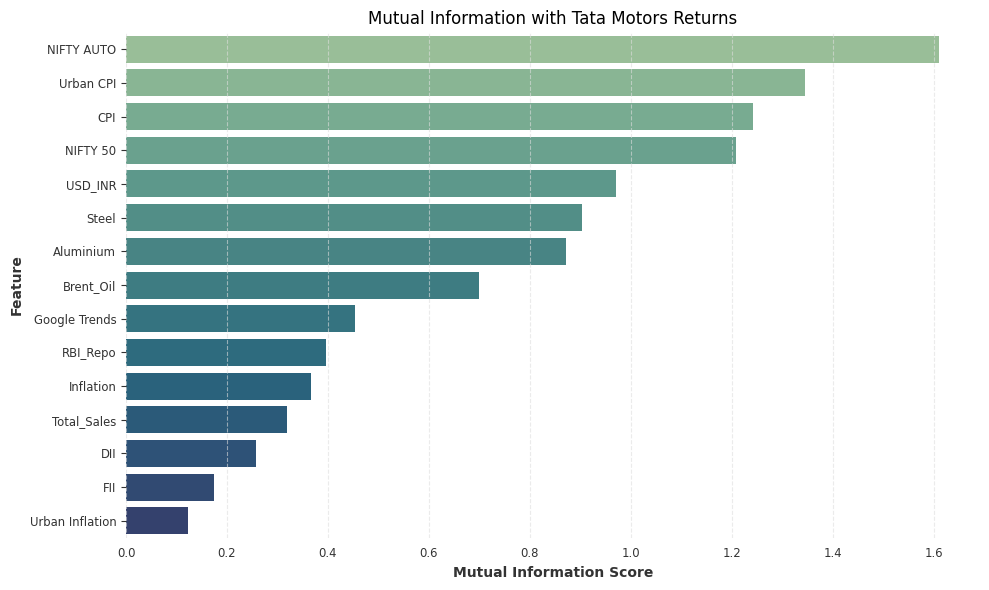

In [187]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np

def compute_mutual_info(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Ensure all features are numeric and aligned
    X = X.select_dtypes(include=np.number).copy()
    y = y.astype(float)

    mi = mutual_info_regression(X, y, discrete_features=False, random_state=42)

    mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi})
    mi_df.sort_values('MI_Score', ascending=False, inplace=True)

    return mi_df
mi_df = compute_mutual_info(df, target_col='TAMO')
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mutual_info(mi_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=mi_df, x='MI_Score', y='Feature', palette='crest')
    plt.title('Mutual Information with Tata Motors Price')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.show()
plot_mutual_info(mi_df)



| Rank | Feature             | MI Score | Interpretation                                                                                                                                          |
| ---- | ------------------- | -------- | ------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1    | **NIFTY AUTO**      | 1.61     | **Strongest nonlinear predictor** — sector sentiment, demand cycles, investor positioning. Likely acts as a **proxy for broader industry dynamics**. |
| 2    | **Urban CPI**       | 1.34     | Strong consumer price influence — suggests **urban inflation/price pressure is tightly linked** to margins, demand elasticity.                      |
| 3    | **CPI**             | 1.24     | General inflation reflects **input cost pressure + monetary policy anticipation**. Adds macro pressure signal.                                      |
| 4    | **NIFTY 50**        | 1.20     | Captures general market conditions. High MI implies Tata’s return is **nonlinearly exposed to market cycles**, not just beta.                        |
| 5    | **USD/INR**         | 0.97     | FX exposure is substantial. Reflects both **import cost volatility and export pricing power** (especially JLR business).                             |
| 6    | **Steel**           | 0.90     | High MI confirms material cost signal. Suggests **nonlinear threshold effects** — sharp cost increases hurt more than small ones.                   |
| 7    | **Aluminium**       | 0.87     | Another key input. Reinforces the importance of **commodities in Tata's cost structure**.                                                            |
| 8    | **Brent Oil**       | 0.70     | Oil prices matter — logistics, plastic, and JLR exposure all tied here.                                                                               |
| 9    | **Google Trends**   | 0.45     | Mild but relevant. Consumer interest likely maps to **retail demand, speculative cycles**, or announcement effects.                                  |
| 10   | **RBI Repo Rate**   | 0.40     | Some nonlinear influence from monetary policy, especially on **financing cost of cars** or investor discounting.                                     |
| 11   | **Inflation**       | 0.37     | Lower than CPI — may reflect aggregation noise or less direct influence.                                                                             |
| 12   | **Total Sales**     | 0.32     | **Direct sales have lower nonlinear MI** — could be due to lag/market anticipates this already.                                          |
| 13   | **DII**             | 0.26     | Weak predictor. Domestic institutional flows may follow rather than lead Tata.                                                                       |
| 14   | **FII**             | 0.17     | Very low MI — **contradicts Granger results**, which suggests **FII is more predictive linearly, not nonlinearly**.                                  |
| 15   | **Urban Inflation** | 0.12     | Possibly redundant with Urban CPI, or multicollinear with CPI already.                                                                               |


# Signal Creation

I have defined some signals from the observations above, these are not in any specific order of priority.

### SIGNAL 1: Auto Sector Relative Strength (ASRS)

If NIFTY AUTO outperforms NIFTY 50, it reflects investor confidence in the auto sector. This signal captures sector-relative positioning and may precede flows into Tata Motors, especially given its significant weight within the index.



Let:
- $( R_{\text{AUTO}, t} = \frac{\text{NIFTY\_AUTO}_t}{\text{NIFTY\_AUTO}_{t-1}} )$
- $( R_{\text{NIFTY}, t} = \frac{\text{NIFTY50}_t}{\text{NIFTY50}_{t-1}} )$

Then the Auto Sector Relative Strength is defined as:

\[
$\text{ASRS}_t = \left( \frac{R_{\text{AUTO}, t}}{R_{\text{NIFTY}, t}} \right) - 1$
\]

This measures the **excess relative return** of the auto sector over the broader market.


In [188]:
df['ASRS'] = ((df['NIFTY AUTO'] / df['NIFTY AUTO'].shift(1)) /
              (df['NIFTY 50'] / df['NIFTY 50'].shift(1))) - 1


### SIGNAL 2: Input Cost Pressure Index (ICPI)

Tata Motors is highly sensitive to fluctuations in input costs such as steel and aluminium prices, as well as currency risk from USD/INR due to its import exposure and global operations. A combined index captures cost inflation pressure, which may affect operating margins and profitability.

Let:
- $ Z_{\text{Steel}, t} $ = Standardized return of steel price over a 3-month rolling window
- $ Z_{\text{Aluminium}, t} $ = Standardized return of aluminium price over a 3-month window
- $ Z_{\text{USD/INR}, t} $ = Standardized return of USD/INR over a 3-month window

Then, the Input Cost Pressure Index is defined as:

$
\text{ICPI}_t = Z_{\text{Steel}, t} + Z_{\text{Aluminium}, t} + Z_{\text{USD/INR}, t}
$

This index acts as a proxy for **cost-side margin pressure**, useful for forecasting downside risk to profitability.


In [189]:
from sklearn.preprocessing import StandardScaler

for col in ['Steel', 'Aluminium', 'USD_INR']:
    df[f'{col}_ret'] = df[col].pct_change()
    
scaler = StandardScaler()
df[['ICPI']] = scaler.fit_transform(df[['Steel_ret', 'Aluminium_ret', 'USD_INR_ret']].sum(axis=1).to_frame())


### SIGNAL 3: Institutional Flow Divergence (IFD)

Foreign Institutional Investors (FIIs) and Domestic Institutional Investors (DIIs) often represent distinct market sentiments. When their net flows diverge — for example, FIIs are net buyers while DIIs are net sellers — it indicates market bifurcation or uncertainty. These divergence periods often precede increased volatility or strong directional moves in stocks like Tata Motors, which are heavily institutionally owned.

Let:
- $ \text{FII}_t $ = Net flow from Foreign Institutional Investors at time \( t \)
- $ \text{DII}_t $ = Net flow from Domestic Institutional Investors at time \( t \)

Then, the Institutional Flow Divergence is defined as:

$
\text{IFD}_t = \frac{\text{FII}_t - \text{DII}_t}{\text{FII}_t + \text{DII}_t}
$

This normalized divergence ratio highlights relative disagreement in institutional positioning.


In [190]:
df['IFD'] = (df['FII'] - df['DII']) / (df['FII'] + df['DII'])


### SIGNAL 4: Regime-Shift Volatility Spread (RSVS)

Tata Motors, being part of the cyclical auto sector, is sensitive to macroeconomic regime changes. A divergence in volatility between key macro indicators and market returns often signals a transition phase—either into risk-off or risk-on environments. This signal captures such transitions that can precede re-pricing in auto sector equities.

#### Mathematical Formulation:

Let:
- $\sigma_{\text{Macro}, t} $ = Rolling standard deviation of a macro basket (USD/INR, CPI, Repo Rate)
- $ \sigma_{\text{Market}, t} $ = Rolling standard deviation of NIFTY AUTO

Then, the Regime-Shift Volatility Spread is:

$
\text{RSVS}_t = \sigma(\text{USD\_INR}, \text{CPI}, \text{Repo})_t - \sigma(\text{NIFTY\_AUTO})_t
$

A **positive RSVS** indicates heightened macro uncertainty relative to market stability — potentially unsustainable — whereas a **negative RSVS** may signal underappreciated risk in the equity market.


In [191]:
macro_vars = df[['USD_INR', 'CPI', 'RBI_Repo']].pct_change().rolling(3).std().mean(axis=1)
auto_vol = df['NIFTY AUTO'].pct_change().rolling(3).std()
df['RSVS'] = macro_vars - auto_vol
df = df.fillna(method='bfill')


In [192]:
df.to_csv('processed_data.csv')

### Lagged Signals

I have included some of the lagged features obtained using the Granger test. 

In [193]:
# === Load monthly data ===
monthly = pd.read_csv("processed_data.csv", parse_dates=["Date"])
monthly.set_index("Date", inplace=True)

# === Load quarterly target ===
quarterly = pd.read_csv("quarterly_data.csv", parse_dates=["Date"])
quarterly.set_index("Date", inplace=True)

# === Apply monthly lags ===
lag_config = {
    "FII": 5,
    "Urban Inflation": 3,
    "Inflation": 3,
    "Steel": 1,
    "Urban CPI": 1,
    "NIFTY AUTO": 6,
    "CPI": 1,
}

# Create lagged columns
lagged_features = {}
for feature, lag in lag_config.items():
    lagged = monthly[feature].shift(lag)
    lagged_quarterly = lagged.resample("Q").last()  # use last available lagged value in quarter
    lagged_features[feature + f"_lag{lag}"] = lagged_quarterly



I am now standardizing the time intervals for quarterly data

In [194]:
# Combine into one DataFrame
X_quarterly = pd.DataFrame(lagged_features)
signal_cols = ['ICPI', 'ASRS', 'IFD', 'RSVS']
for col in signal_cols :
    X_quarterly[col] = monthly[col].resample("Q").sum()
# Align with target

data = X_quarterly.join(quarterly, how="inner").dropna()
data.to_csv('processed_data_quarterly.csv')

# Forecasting Quarterly Profits


# Model 1: Liner Regression

I begin with a basic linear regression model to estabilish a baseline model. I did try polynomial regression as well, but it gave poor results as expected. 

R² = -24.005, RMSE = 3459.49


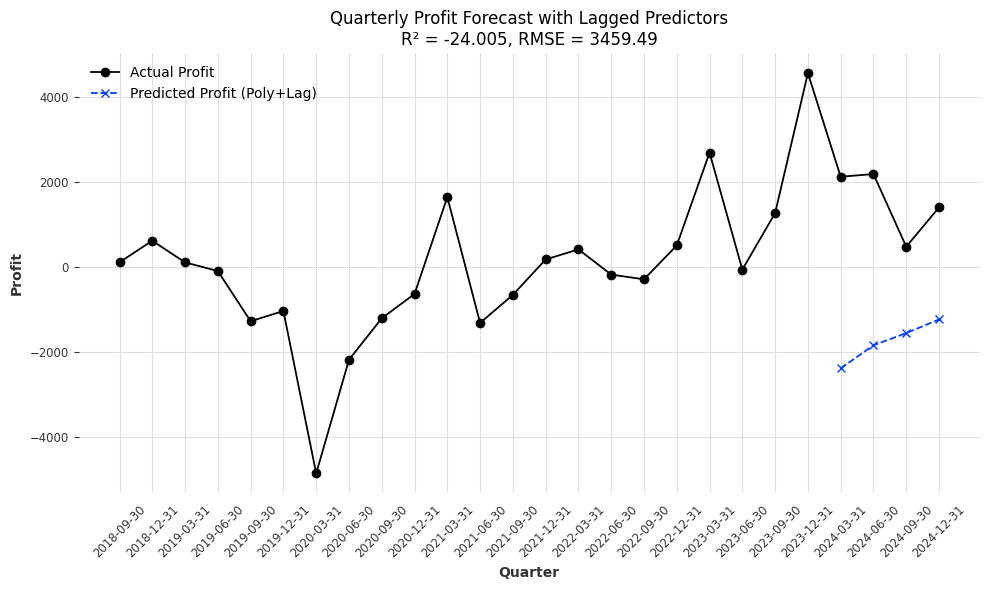

In [195]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt

data = pd.read_csv('processed_data_quarterly.csv')
data.set_index("Date", inplace=True)

X = data.drop(columns=["Profit"])
y = data["Profit"]

# Train-test split
X_train, X_test = X.iloc[:-4], X.iloc[-4:]
y_train, y_test_lin = y.iloc[:-4], y.iloc[-4:]

# Polynomial regression pipeline
pipeline = Pipeline([
    ("linreg", LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred_lin = pipeline.predict(X_test)

# Evaluate
r2 = r2_score(y_test_lin, y_pred_lin)
rmse = root_mean_squared_error(y_test_lin, y_pred_lin)
print(f"R² = {r2:.3f}, RMSE = {rmse:.2f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y.index, y.values, label="Actual Profit", marker="o")
plt.plot(y_test_lin.index, y_pred_lin, label="Predicted Profit (Poly+Lag)", marker="x", linestyle="--")
plt.title(f"Quarterly Profit Forecast with Lagged Predictors\nR² = {r2:.3f}, RMSE = {rmse:.2f}")
plt.xlabel("Quarter")
plt.ylabel("Profit")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The results obtained here aren't very great but a major cause of the poor results is the use of a simple linear regression model

### Model 2: XGBoost
I'll now use a more complex XGBoost Model to hopefully improve results

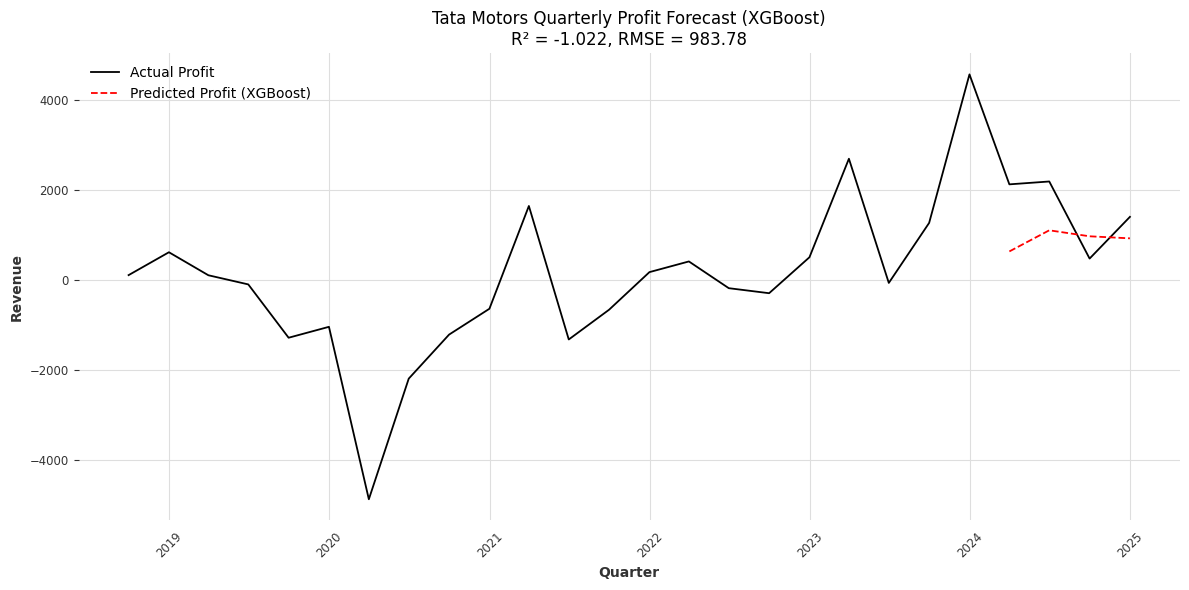

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load and preprocess data
df = pd.read_csv("processed_data_quarterly.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

# Feature-target split
X = df.drop(columns=["Profit"])
y = df["Profit"]

# Train-test split (last 4 quarters for test)
X_train, X_test_xgb = X.iloc[:-4], X.iloc[-4:]
y_train, y_test_xgb = y.iloc[:-4], y.iloc[-4:]

# Initialize and fit XGBoost model
model_xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = model_xgb.predict(X_test_xgb)

# Evaluation
r2 = r2_score(y_test_xgb, y_pred_xgb)
rmse = root_mean_squared_error(y_test_xgb, y_pred_xgb)

# Construct prediction series for plotting
full_actual = y.copy()
predicted_series = pd.Series(data=y_pred_xgb, index=y_test_xgb.index)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(full_actual.index, full_actual.values, label="Actual Profit")
plt.plot(predicted_series.index, predicted_series.values, label="Predicted Profit (XGBoost)", linestyle='--',color ='red')
plt.title(f"Tata Motors Quarterly Profit Forecast (XGBoost)\nR² = {r2:.3f}, RMSE = {rmse:.2f}")
plt.xlabel("Quarter")
plt.ylabel("Revenue")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This is working much better compared to the baseline, but there is still room for improvement. I would look into expanding the size of the dataset as we are only looking at the past 5 years.

### Model 3: Time Fusion Transformer

For my most complex model, I am using a pre-trained Temporal Fusion Transformer from the darts library to predict profits by fine tuning it on the available data. I am open to surprises here, but will not keep a lot of high hopes as big models like this need a lot of data(which we don't have).

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.0 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_cont

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

R^2 Score: -3.2537345645106273
RMSE: 1443.9653931268285


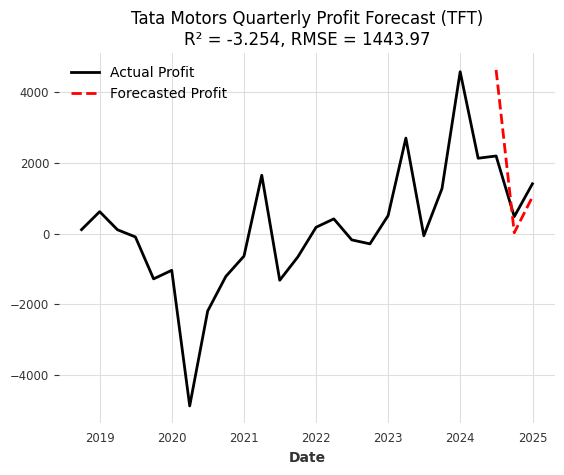

In [ ]:
# import pandas as pd
# import torch
# from pytorch_lightning import Trainer
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# from darts import TimeSeries
# from darts.models import TFTModel
# from darts.utils.likelihood_models.torch import QuantileRegression
# from darts.metrics import rmse, r2_score
# from darts.dataprocessing.transformers import Scaler
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# df = pd.read_csv('processed_data_quarterly.csv')
# df["Date"] = pd.to_datetime(df["Date"])
# df.set_index("Date", inplace=True)

# # Create Darts TimeSeries
# target_series = TimeSeries.from_series(df["Profit"])
# covariates = TimeSeries.from_dataframe(df.drop("Profit", axis=1))

# # Scale series
# scaler_target = Scaler(StandardScaler())
# scaler_cov = Scaler(StandardScaler())
# target_scaled = scaler_target.fit_transform(target_series)
# cov_scaled = scaler_cov.fit_transform(covariates)

# # Train/Test split
# train_size = len(df) - 3
# target_train, target_test_1 = target_scaled[:train_size], target_scaled[train_size:]
# cov_train, cov_test_1 = cov_scaled[:train_size], cov_scaled[train_size:]

# # Define and train model

# # GPU config
# pl_trainer_kwargs = {
#     "accelerator": "gpu",
#     "devices": -1, 
#     "log_every_n_steps": 10
# }

# # TFT Model
# model_tft = TFTModel(
#     input_chunk_length=4,
#     output_chunk_length=2,
#     hidden_size=64, 
#     lstm_layers=4,
#     num_attention_heads=12,       
#     dropout=0.1,
#     batch_size=32,
#     n_epochs=100,
#     add_relative_index=True,
#     random_state=42,
#     likelihood=QuantileRegression(), 
#     pl_trainer_kwargs=pl_trainer_kwargs
# )
# model_tft.fit(target_train, past_covariates=cov_train)

# # Forecast
# forecast = model_tft.predict(n=3, past_covariates=cov_scaled)

# # Inverse transform
# forecast_unscaled = scaler_target.inverse_transform(forecast)
# target_test_unscaled = scaler_target.inverse_transform(target_test_1)

# # Evaluation
# r2 = r2_score(target_test_unscaled, forecast_unscaled)
# rmse = rmse(target_test_unscaled, forecast_unscaled)
# print("R^2 Score:", r2)
# print("RMSE:", rmse)

# # Plot
# target_series.plot(label="Actual Profit")
# forecast_unscaled.plot(label="Forecasted Profit",color='red',linestyle='--')
# plt.title(f"Tata Motors Quarterly Profit Forecast (TFT)\nR² = {r2:.3f}, RMSE = {rmse:.2f}")
# plt.legend()
# plt.show()

The model does resonably well, the error metrics are higher than that of the XGBoost model but it was able to track the profile of the ground truth data. This shows a lot of scope for improvement with data and compute scaling.

# Forecasting Share Price


### Model 1: Time Fusion Transformer
I am using a pretrained Temporal Fusion Transformer from the Darts library as earlier but modified to forecast the share price over monthly interval data.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 47.3 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_cont

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

R^2 Score: nan
RMSE: nan


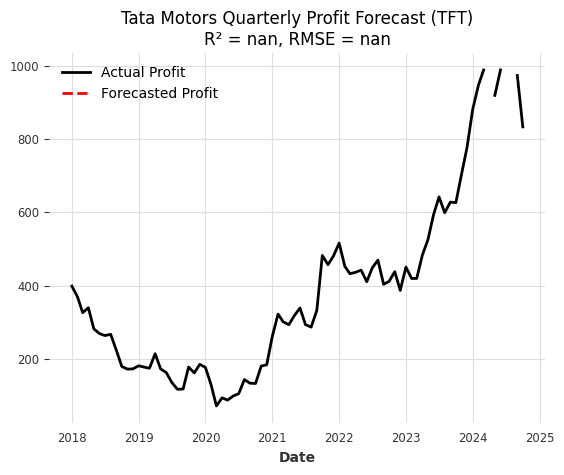

In [ ]:
# import pandas as pd
# import torch
# from pytorch_lightning import Trainer
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# from darts import TimeSeries
# from darts.models import TFTModel
# from darts.utils.likelihood_models.torch import QuantileRegression
# from darts.metrics import rmse, r2_score
# from darts.dataprocessing.transformers import Scaler
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# df = pd.read_csv('processed_data.csv')
# df["Date"] = pd.to_datetime(df["Date"])
# df.set_index("Date", inplace=True)

# # Create Darts TimeSeries
# target_series = TimeSeries.from_series(df["TAMO"],freq='MS')
# covariates = TimeSeries.from_dataframe(df.drop("TAMO", axis=1),freq='MS')

# # Scale series
# scaler_target = Scaler(StandardScaler())
# scaler_cov = Scaler(StandardScaler())
# target_scaled = scaler_target.fit_transform(target_series)
# cov_scaled = scaler_cov.fit_transform(covariates)

# # Train/Test split
# train_size = len(df) - 3
# target_train, target_test_1 = target_scaled[:train_size], target_scaled[train_size:]
# cov_train, cov_test_1 = cov_scaled[:train_size], cov_scaled[train_size:]

# # Define and train model

# # GPU config
# pl_trainer_kwargs = {
#     "accelerator": "gpu",
#     "devices": -1, 
#     "log_every_n_steps": 10
# }

# # TFT Model
# model_tft = TFTModel(
#     input_chunk_length=4,
#     output_chunk_length=2,
#     hidden_size=64, 
#     lstm_layers=4,
#     num_attention_heads=12,       
#     dropout=0.1,
#     batch_size=32,
#     n_epochs=100,
#     add_relative_index=True,
#     random_state=42,
#     likelihood=QuantileRegression(), 
#     pl_trainer_kwargs=pl_trainer_kwargs
# )
# model_tft.fit(target_train, past_covariates=cov_train)

# # Forecast
# forecast = model_tft.predict(n=3, past_covariates=cov_scaled)

# # Inverse transform
# forecast_unscaled = scaler_target.inverse_transform(forecast)
# target_test_unscaled = scaler_target.inverse_transform(target_test_1)

# # Evaluation
# r2 = r2_score(target_test_unscaled, forecast_unscaled)
# rmse = rmse(target_test_unscaled, forecast_unscaled)
# print("R^2 Score:", r2)
# print("RMSE:", rmse)

# # Plot
# target_series.plot(label="Actual Profit")
# forecast_unscaled.plot(label="Forecasted Profit",color='red',linestyle='--')
# plt.title(f"Tata Motors Quarterly Profit Forecast (TFT)\nR² = {r2:.3f}, RMSE = {rmse:.2f}")
# plt.legend()
# plt.show()

This doesn't work too well due to the small set of training data and the large model size, perharps I should focus on smaller models.

### Model 2: XGBoost
Moving down to our trusted buddy, the XGBoost model for the same task is expected to improve performance

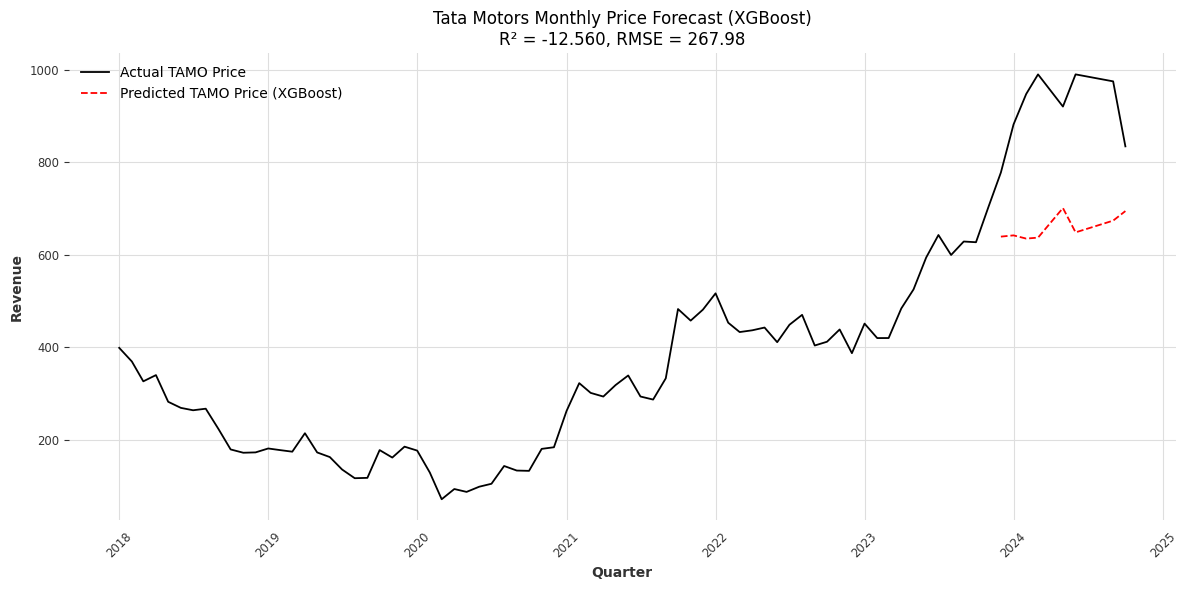

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load and preprocess data
df = pd.read_csv("processed_data.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

# Feature-target split
X = df.drop(columns=["TAMO"])
y = df["TAMO"]

# Train-test split (last 10 months for test)
X_train, X_test = X.iloc[:-8], X.iloc[-8:]
y_train, y_test = y.iloc[:-8], y.iloc[-8:]

# Initialize and fit XGBoost model
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

# Construct prediction series for plotting
full_actual = y.copy()
predicted_series = pd.Series(data=y_pred, index=y_test.index)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(full_actual.index, full_actual.values, label="Actual TAMO Price")
plt.plot(predicted_series.index, predicted_series.values, label="Predicted TAMO Price (XGBoost)", linestyle='--',color ='red')
plt.title(f"Tata Motors Monthly Price Forecast (XGBoost)\nR² = {r2:.3f}, RMSE = {rmse:.2f}")
plt.xlabel("Quarter")
plt.ylabel("Revenue")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The XGBoost Model fits the data better, but the results are not great as shown by the poor-mediocre R2 and RMSE scores. A major cause for that is the sudden shift in the trend of the price after the first quarter of 2024, which is not being learnt well by the model due to the small dataset

# Validation

Here, I analyze the results of each of the models and understand their performance. I am also analyzing the developed signals to ensure that they are relevent to the data.

### Analysis of Model 1 - Linear Regression

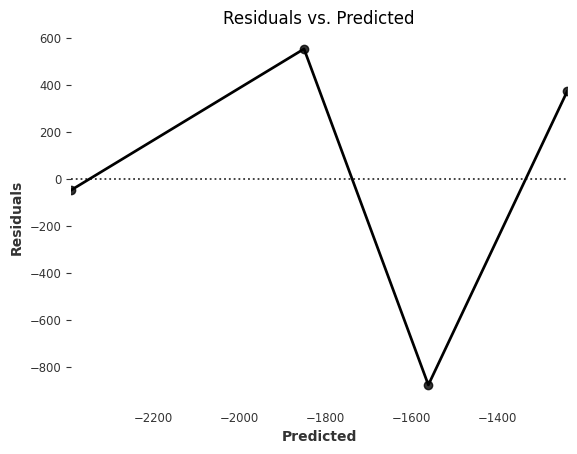

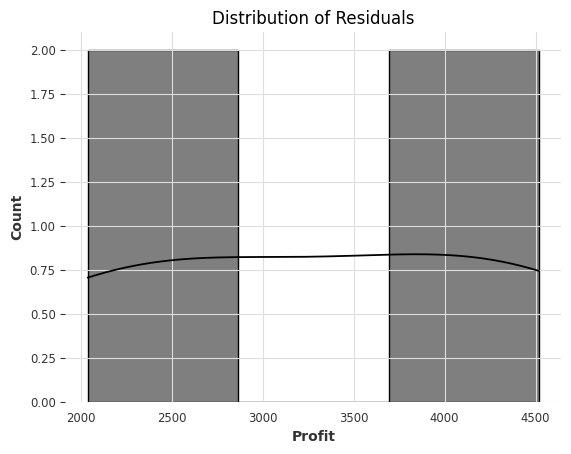

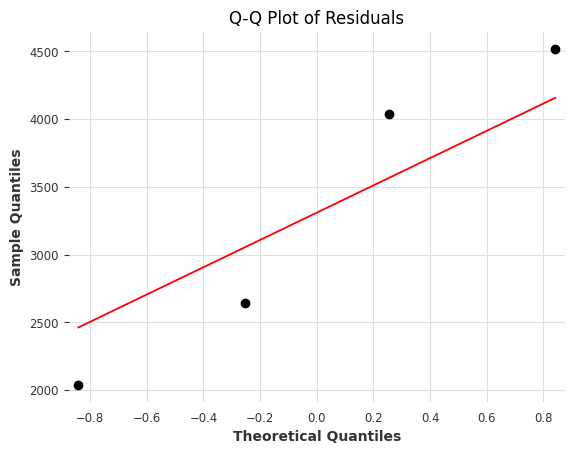

Shapiro-Wilk p-value: 0.5649


In [200]:
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

residuals = y_test_lin - y_pred_lin

# Residual plot
sns.residplot(x=y_pred_lin, y=residuals, lowess=True)
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid()
plt.show()

# Histogram
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()

# Q-Q Plot for normality
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

# Shapiro-Wilk Test
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {p:.4f}")


- The residuals show poor fitting of the data as seen by the irregular structure.

- The Q-Q plot of residuals aligns somewhat with the normal line, suggesting that the residuals are approximately normally distributed (not great though).

- The distribution of the residuals is forming a somewhat bell curve, indicating that there is still information left to be learnt.

- The Shapiro-Wilk test returned a p-value of 0.6177, indicating no statistically significant deviation from normality in the residuals, but it is significantly hampered by the fact that only 4 test points are taken.

These tests are not fully valid here as I have used only 4 years' worth of quarterly data to train, and 1 year of quarterly results to test. Ideally more data is needed.

### Model 2 - XGBoost

Let's begin by analyzing the feature importance as this is a non-linear model and it can give some insight to the effectiveness of thes signals

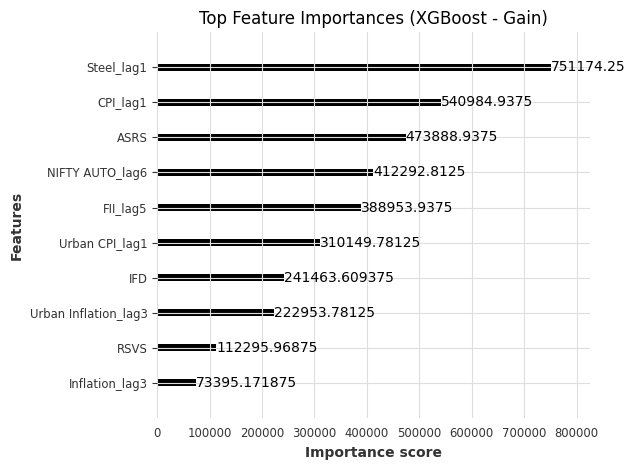

In [201]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model_xgb, importance_type='gain', max_num_features=10)
plt.title("Top Feature Importances (XGBoost - Gain)")
plt.tight_layout()
plt.show()


I'll now look at the SHAP to understand feature impact across predictions

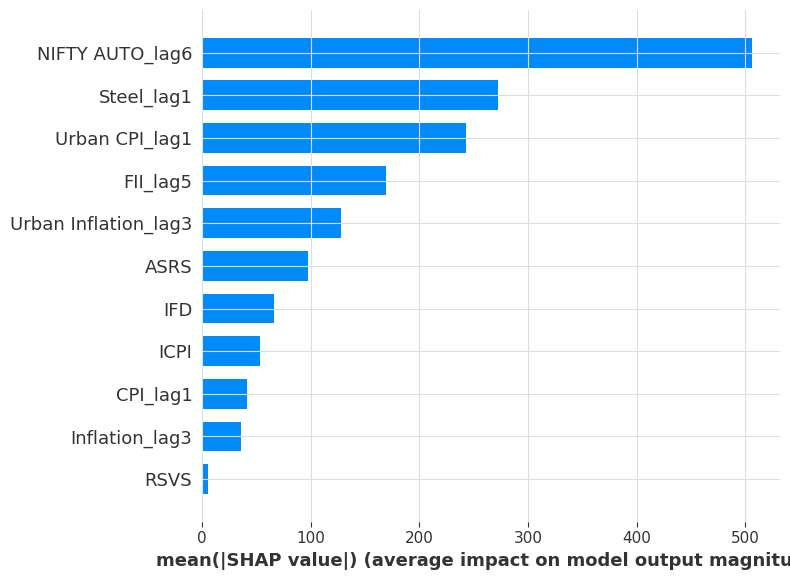

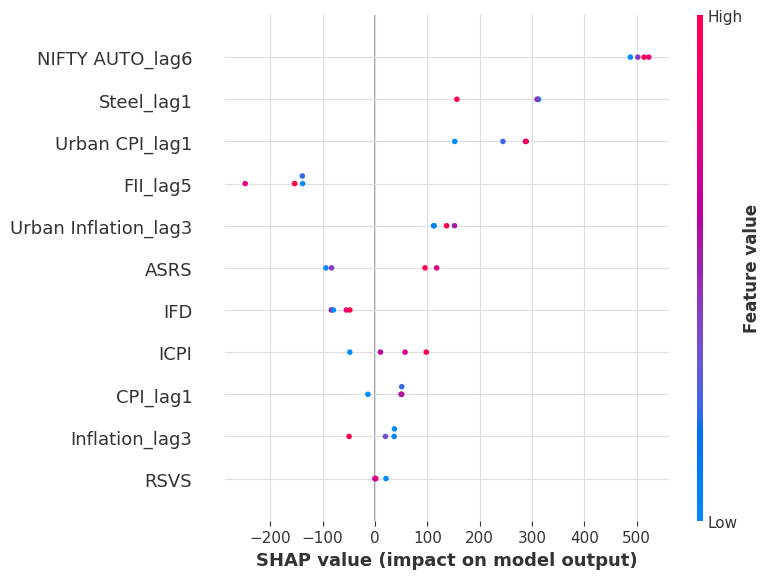

In [202]:
import shap
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_test_xgb)

shap.summary_plot(shap_values, X_test_xgb, plot_type="bar")
shap.summary_plot(shap_values, X_test_xgb)


This clearly shows the value of the lagged features that have been added in, also highlights that the engineered signals were useful for the XGBoost Model.

## Analysis of the Signals Developed

Top Pearson correlations:
 Profit             1.000000
NIFTY AUTO_lag6    0.633274
CPI_lag1           0.573492
Urban CPI_lag1     0.568834
Steel_lag1         0.360673
ASRS               0.044894
IFD                0.035507
RSVS              -0.063253
ICPI              -0.093027
FII_lag5          -0.163242
Name: Profit, dtype: float64

Top Spearman correlations:
 Profit             1.000000
NIFTY AUTO_lag6    0.749060
CPI_lag1           0.568547
Urban CPI_lag1     0.563761
Steel_lag1         0.367521
ASRS               0.292308
ICPI               0.244444
IFD                0.196581
FII_lag5          -0.099487
Inflation_lag3    -0.224654
Name: Profit, dtype: float64


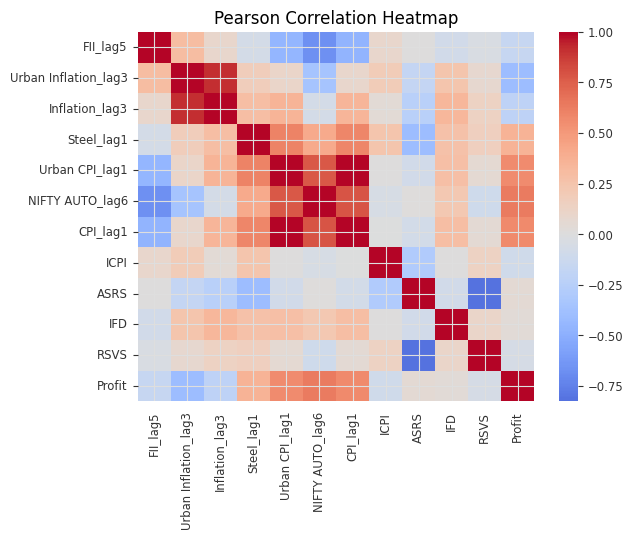

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('processed_data_quarterly.csv')
df.set_index("Date", inplace=True)


# Pearson and Spearman 
pearson_corr = df.corr()['Profit'].sort_values(ascending=False)
spearman_corr = df.corr(method='spearman')['Profit'].sort_values(ascending=False)

print("Top Pearson correlations:\n", pearson_corr.head(10))
print("\nTop Spearman correlations:\n", spearman_corr.head(10))


# Plot heatmap
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Pearson Correlation Heatmap")
plt.show()



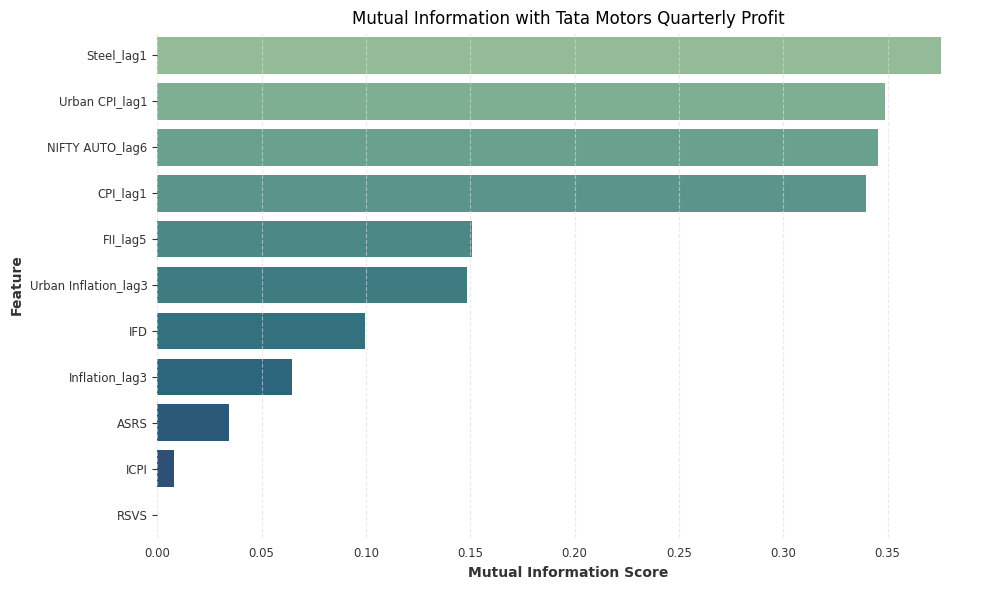

In [227]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np

def compute_mutual_info(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Ensure all features are numeric and aligned
    X = X.select_dtypes(include=np.number).copy()
    y = y.astype(float)

    mi = mutual_info_regression(X, y, discrete_features=False, random_state=42)

    mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi})
    mi_df.sort_values('MI_Score', ascending=False, inplace=True)

    return mi_df

mi_df = compute_mutual_info(df, target_col='Profit')
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mutual_info(mi_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=mi_df, x='MI_Score', y='Feature', palette='crest')
    plt.title('Mutual Information with Tata Motors Quarterly Profit')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.show()
plot_mutual_info(mi_df)



| Rank | Feature                         | MI Score | Interpretation                                                                                     |
| ---- | ------------------------------- | -------- | ----------------------------------------------------------------------------------------------------------------------- |
| 1    | **Steel\_lag1**                 | 0.375    | Steel prices are a **key input cost** for auto manufacturers. A 1-month lag shows **cost pressures** impacting margins. |
| 2    | **Urban CPI\_lag1**             | 0.349    | Indicates **urban consumer inflation**, which affects **automobile demand** especially for discretionary spending.      |
| 3    | **NIFTY AUTO\_lag6**            | 0.345    | Lagged 6 months, this captures **industry sentiment** and cyclicality; possibly reflects **investment cycle lags**.     |
| 4    | **CPI\_lag1**                   | 0.340    | General inflation impacts both **input costs** and **consumer purchasing power**; lags account for delayed effects.     |
| 6    | **Urban Inflation\_lag3**       | 0.155    | Captures **delayed inflation effects** on urban consumption and financing costs (e.g., loans).                          |
| 7    | **FII\_lag5**                   | 0.151    | Foreign investments indicate **macro confidence**; lag of 5 months may capture policy or credit cycle effects.          |
| 8    | **IFD (Infra Development)**     | 0.100    | Infrastructure growth supports **CV sales** and overall logistics; contributes indirectly to auto demand.               |
| 9    | **Inflation\_lag3**             | 0.065    | Another inflation proxy with longer lag; may reflect **cumulative price pressures** on consumers.                       |
| 10   | **RISS (Rural Sentiment)**      | 0.043    | Indicates **rural demand sentiment**, relevant for **entry-level vehicles** and two-wheelers.                           |
| 11   | **ASRS (Auto Sales sentiment)** | 0.034    | Tracks **investor/media sentiment** on auto sales; a **soft signal** likely used by institutional analysts.             |
